<a href="https://colab.research.google.com/github/varda0/PhishShield-AI/blob/main/AI_PhishingDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import re
import torch

#libraries for data explore
import seaborn as sns
import matplotlib.pyplot as plt

#libraries for Model training and evaluation
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
from datasets import Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [2]:
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/phishing_email.csv')
df.shape

Mounted at /content/drive


(82486, 2)

In [3]:
# Randomly sample 15,000 rows from the full dataset
df = df.sample(n=15000, random_state=42).reset_index(drop=True)

print(df.head())

                                       text_combined  label
0  endangered languages workshop foundation endan...      0
1  claretta claretta_bordersfusemailcom cialis wo...      1
2  roger upole schkeramsncom kyle rickey wrote im...      0
3  barclays customer service testlightworldcojp d...      1
4  gmm 09 nov 2001 please find attached global ma...      0


**Preprocess the Data**

*   Remove null
*   Lowercasing :BERT handles case, but lowercase helps traditional models
Preprocessing Steps Not Applied (with Justifications)


*   Remove URLs : URLs are strong indicators of phishing, so we keep them as features.
*   Remove special characters : Symbols like @, !, $, etc., are commonly used in phishing tactics and should be retained.
*   Remove punctuation : Punctuation may be part of deceptive formatting or URLs, so we do not remove it.
*.  Remove numbers : Numbers (like fake invoice IDs or OTPs) may signal phishing intent, so we preserve them.
*.  Remove stopwords : Common words may carry phishing signals in certain contexts, so we keep them for now.
*.  Remove capital letters : Capitalization (e.g., “URGENT”) often indicates phishing, so we retain letter casing.
*   Stemming or Lemmatization : We keep words in their original form to preserve possible phishing-related phrasing.
*   Remove HTML tags : Some phishing emails use HTML tricks; we want to analyze them if present.
*   Spelling correction : Typos and misspellings may be deliberate in phishing emails, so we avoid correcting them.

In [4]:
# Remove nulls
df.dropna(inplace=True)

df['label'] = df['label'].astype(int)

# Lowercasing only
def clean_text(text):
    return text.lower()

df['text_combined'] = df['text_combined'].apply(clean_text)

In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text_combined  15000 non-null  object
 1   label          15000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 234.5+ KB
None


In [6]:
df.shape

(15000, 2)

In [7]:
df.tail()

,text_combined,label
14995,winning notification dalobica lotto bv interna...,1
14996,become happy performance girlfriend loves resu...,1
14997,looks good obviously close originally suggest...,0
14998,cnn alerts frakte_1973emmeffenet cnn alerts cu...,1
14999,danny graham ingridchianghadleybuytaertnet syo...,1


**Explore the dataset**

Plot Class Distribution

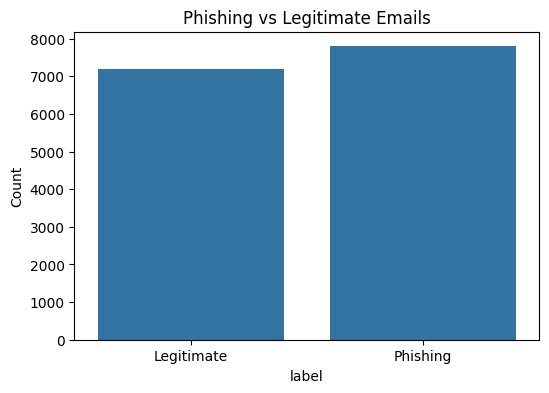

In [8]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='label') # counts the number of occurrences of each unique value in a column
plt.title('Phishing vs Legitimate Emails')
plt.xticks([0, 1], ['Legitimate', 'Phishing'])
plt.ylabel('Count')
plt.show()

**Email/Text special character Length Distribution by Class**

This graph is a boxplot comparing the number of special characters used in legitimate vs phishing emails.

Special characters: ! @ # $ % ^ & * ( ) _ + = { } [ ] : ; " ' < > / ? , . ~ etc.

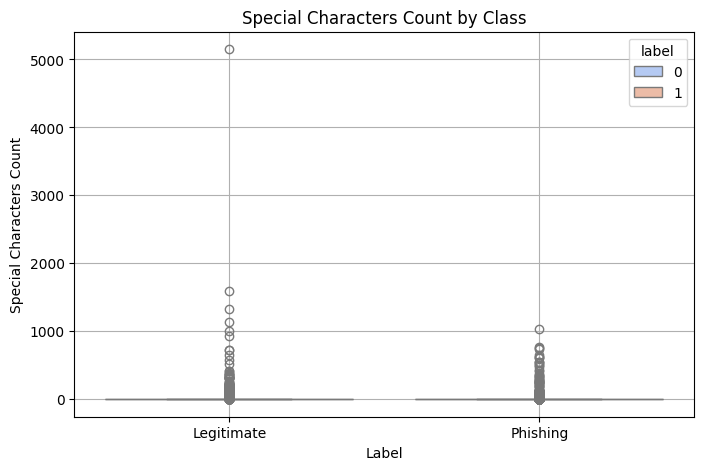

In [9]:
df['special_chars'] = df['text_combined'].apply(lambda x: sum(not c.isalnum() and not c.isspace() for c in x))

plt.figure(figsize=(8,5))
sns.boxplot(x='label', y='special_chars', data=df, hue='label', palette='coolwarm', dodge=False)

plt.xticks([0, 1], ['Legitimate', 'Phishing'])
plt.title('Special Characters Count by Class')
plt.xlabel('Label')
plt.ylabel('Special Characters Count')
plt.grid(True)
plt.show()

*Most Common words*

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


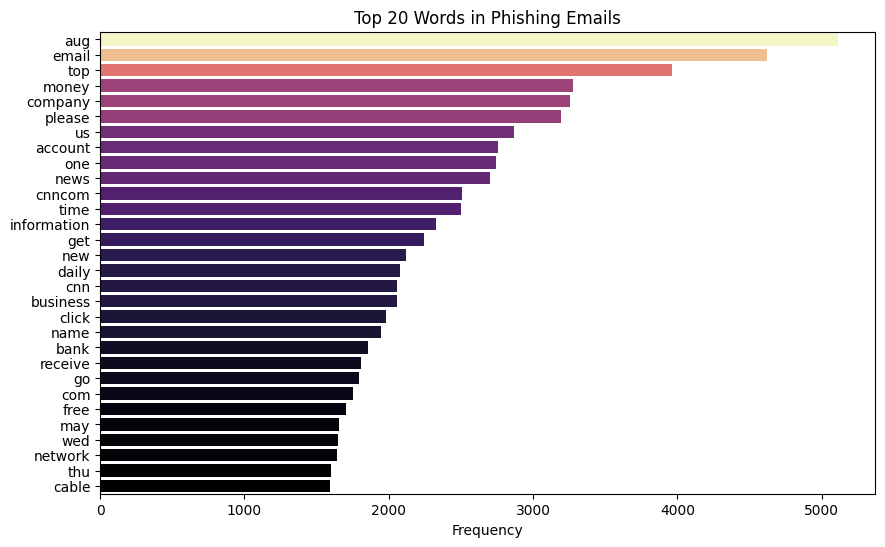

In [10]:
from collections import Counter
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')


stop_words = set(stopwords.words('english'))  #e.g., "the", "is", "and"

# Combine all phishing emails: Joins all texts into one string → converts to lowercase → splits into words
phishing_words = ' '.join(df[df['label']==1]['text_combined']).lower().split() #Selects only phishing emails (where label == 1)

filtered_words = [word for word in phishing_words if word.isalpha() and word not in stop_words] #Alphabetic words (removes numbers, punctuation)

word_freq = Counter(filtered_words).most_common(30)

# Barplot of top words
words, counts = zip(*word_freq)  #Unpacks the 20 most common word–count pairs into two separate lists: words and counts
plt.figure(figsize=(10,6))
sns.barplot(x=list(counts), y=list(words),hue =list(counts), palette='magma',legend=False)
plt.title('Top 20 Words in Phishing Emails')
plt.xlabel('Frequency')
plt.show()

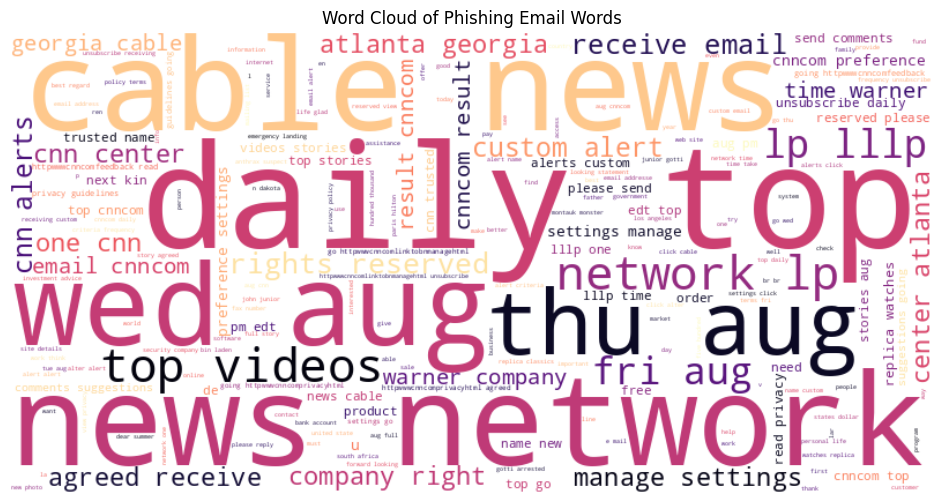

In [11]:
from wordcloud import WordCloud

# Join all filtered phishing words into a single string
wordcloud_text = ' '.join(filtered_words)

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='magma').generate(wordcloud_text)

# Display the word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Phishing Email Words')
plt.show()

**Split the Dataset in training , validation and test**

In [12]:
from sklearn.model_selection import train_test_split

# 1. First, split out 20% test data

train_val_texts, test_texts, train_val_labels, test_labels = train_test_split(df['text_combined'].tolist(), df['label'].tolist(), test_size=0.2, random_state=42, stratify=df['label'])

# 2. Then split remaining 80% into 70% train and 10% val

train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_val_texts, train_val_labels,
    test_size=0.125,  # 10% of total = 12.5% of the remaining 80%
    random_state=42, stratify=train_val_labels
)

**Tokenization using BERT Tokenizer**

These encodings are the tokenized versions of your input texts, structured in a way that BERT can understand

In [13]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenize the datasets
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [14]:
print(train_encodings['input_ids'][0])          # View input IDs of the first text
print(train_encodings['attention_mask'][0])

[101, 17264, 7027, 2373, 3001, 3204, 3283, 2218, 3116, 5395, 3288, 2362, 3001, 3136, 3293, 2111, 3625, 12697, 2311, 17264, 7027, 3001, 2763, 3174, 2111, 2164, 7014, 2566, 12624, 4938, 2154, 7113, 7014, 10439, 14511, 2080, 3960, 2534, 8886, 17891, 6746, 6927, 3902, 3762, 6754, 24185, 21007, 2063, 7369, 2014, 19333, 6264, 6606, 3889, 14085, 5076, 20105, 16215, 6072, 2050, 5297, 11623, 2928, 27078, 8512, 6519, 10524, 2116, 2048, 17817, 4484, 3116, 2034, 3154, 9129, 2111, 2551, 9033, 10483, 7014, 2177, 3225, 2831, 4938, 2177, 2609, 6337, 2136, 3931, 20105, 9352, 26351, 2014, 19333, 25212, 2015, 4372, 2050, 3043, 2264, 4372, 2050, 2225, 4372, 2050, 3872, 2968, 19387, 2080, 7617, 2111, 3331, 2028, 2178, 2117, 3154, 6343, 2699, 4949, 4072, 4972, 4906, 2362, 13487, 6927, 3902, 3762, 28762, 8925, 6746, 5247, 3204, 3331, 2177, 5059, 3861, 3001, 2499, 4906, 2362, 2716, 3232, 2111, 9669, 5397, 6509, 2622, 2373, 8400, 8312, 5491, 9556, 2052, 8627, 2298, 5530, 2340, 2321, 7680, 7849, 4697, 3314, 114

**Convert to HuggingFace Dataset**

A custom PyTorch dataset class for handling tokenized email text data and labels.

* Inherits: torch.utils.data.Dataset
* Purpose: Feeds input to Hugging Face Trainer in a structured format.
Methods:

__init__(self, encodings, labels)
Stores tokenized input data (encodings) and labels.

__getitem__(self, idx)
Returns the input tensors and label for a specific index.

Example output:

{

  'input_ids': tensor(...),

  'attention_mask': tensor(...),

  'labels': tensor(...)

}

__len__(self)

Returns the total number of samples.

**Data input format for bert**

* input_ids: Token IDs representing the input text.

* attention_mask: Binary mask to distinguish real tokens (1) from padding (0).

* labels: True class values used for supervised learning.

[CLS]: Special token added at the start of input for classification tasks.

[SEP]: Separator token marking the end of a sentence or segment.

In [15]:
class EmailDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = EmailDataset(train_encodings, train_labels)
val_dataset = EmailDataset(val_encodings, val_labels)

**Load Pretrained BERT for Classification**

In [16]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**Define Evaluation Metrics**

In [17]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

**Training Arguments**

TrainingArguments is a configuration class that defines how your model should be trained.
You pass it key training parameters such as:

* output_dir: Where to save model checkpoints.
* learning_rate: Controls how fast the model learns.
* num_train_epochs: Number of complete passes through the training data.
* evaluation_strategy: When to run validation (e.g., "epoch" means after every epoch).
* per_device_train_batch_size: Batch size per GPU/CPU device during training.
* logging_dir: Directory to store training logs.

It does not train the model — it only stores training settings that the Trainer will use.

In [18]:
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy="epoch",       # Validates after each epoch
    save_strategy="epoch",             # Saves checkpoint after each epoch
    save_total_limit=2,                # Keep only last 2 checkpoints
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    optim="adamw_torch",
    logging_dir='./logs',
    logging_strategy="epoch",          # Log once per epoch
    load_best_model_at_end=True,       # Optional: load best val score model
    metric_for_best_model="f1",        # Based on compute_metrics
    greater_is_better=True             # Because higher F1 is better
)

**Trainer**

Trainer is the training engine provided by Hugging Face. It handles the full model training lifecycle. Specifically, it:

* Loads and trains your model.
* Handles batching, shuffling, and tokenization.
* Trains the model using PyTorch under the hood.
* Evaluates the model on your eval_dataset.
* Uses the settings defined in TrainingArguments.
* Automatically supports training on GPU or TPU if available.
* Trainer simplifies the process so you don’t need to manually write training loops, backpropagation, or optimizer logic.

In [19]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics
)

/tmp/ipython-input-3673888053.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [20]:
trainer.train()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: varda1427 (varda1427-d-y-patil-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.163400,0.075970,0.976667,0.977778,0.967337,0.988447
2,0.042700,0.056681,0.982000,0.982547,0.989583,0.975610
3,0.011800,0.084031,0.986000,0.986530,0.985897,0.987163
4,0.005500,0.090737,0.983333,0.983902,0.987080,0.980745
5,0.000800,0.090583,0.984667,0.985209,0.987113,0.983312


TrainOutput(global_step=3285, training_loss=0.04485262294882509, metrics={'train_runtime': 5119.4096, 'train_samples_per_second': 10.255, 'train_steps_per_second': 0.642, 'total_flos': 1.38133304064e+16, 'train_loss': 0.04485262294882509, 'epoch': 5.0})

**Plot Accuracy and Loss vs Epoch**

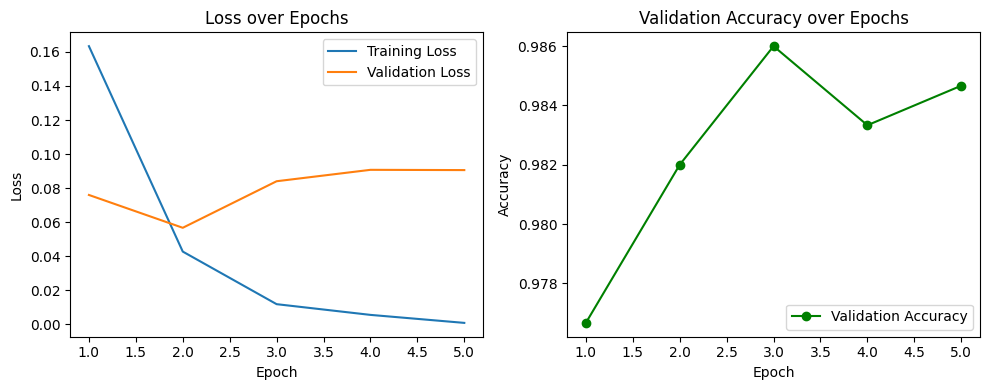

In [21]:
import matplotlib.pyplot as plt

# Extract logs
log_history = trainer.state.log_history

# Gather data
train_loss = [entry['loss'] for entry in log_history if 'loss' in entry]
eval_loss = [entry['eval_loss'] for entry in log_history if 'eval_loss' in entry]
eval_acc  = [entry['eval_accuracy'] for entry in log_history if 'eval_accuracy' in entry]
epochs = list(range(1, len(eval_loss)+1))

# Plot loss
plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, eval_loss, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, eval_acc, marker='o', color='green', label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy over Epochs")
plt.legend()

plt.tight_layout()
plt.show()

In [24]:
model_dir = "/content/drive/MyDrive/phishing_model"

# Save model and tokenizer
model.save_pretrained(model_dir)
tokenizer.save_pretrained(model_dir)

('/content/drive/MyDrive/phishing_model/tokenizer_config.json',
 '/content/drive/MyDrive/phishing_model/special_tokens_map.json',
 '/content/drive/MyDrive/phishing_model/vocab.txt',
 '/content/drive/MyDrive/phishing_model/added_tokens.json')

In [28]:
from transformers import BertForSequenceClassification, BertTokenizer

model = BertForSequenceClassification.from_pretrained("/content/drive/MyDrive/phishing_model")
tokenizer = BertTokenizer.from_pretrained("/content/drive/MyDrive/phishing_model")

**Test the model**

Tokenize test data

In [29]:
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

**Convert to Py Torch Dataset**

In [30]:
test_dataset = EmailDataset(test_encodings, test_labels)

**Evaluate model on test set**

In [31]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Run predictions on the test set
test_results = trainer.predict(test_dataset)

# Extract predicted class labels
y_pred = test_results.predictions.argmax(axis=1)
y_true = test_labels  # Make sure test_labels is a list of integers

# Print all core metrics
print("Final Test Evaluation Metrics:\n")
print("Accuracy       :", accuracy_score(y_true, y_pred))
print("Precision      :", precision_score(y_true, y_pred))
print("Recall         :", recall_score(y_true, y_pred))
print("F1 Score       :", f1_score(y_true, y_pred))
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=["Legitimate", "Phishing"]))

Final Test Evaluation Metrics:

Accuracy       : 0.9876666666666667
Precision      : 0.9903350515463918
Recall         : 0.9858883899935856
F1 Score       : 0.9881067180970748

Classification Report:
               precision    recall  f1-score   support

  Legitimate       0.98      0.99      0.99      1441
    Phishing       0.99      0.99      0.99      1559

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000



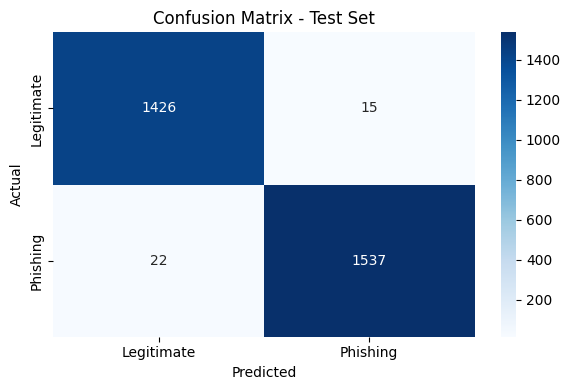

In [32]:
# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Legitimate', 'Phishing'], yticklabels=['Legitimate', 'Phishing'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Test Set')
plt.tight_layout()
plt.show()

In [33]:
from sklearn.metrics import classification_report

y_pred = test_results.predictions.argmax(axis=1)
print(classification_report(test_labels, y_pred, target_names=["Legitimate", "Phishing"]))

              precision    recall  f1-score   support

  Legitimate       0.98      0.99      0.99      1441
    Phishing       0.99      0.99      0.99      1559

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000

